# Credit
Many thanks for Radek's [monkey patch](https://github.com/radekosmulski/rsna-intracranial/blob/master/03_train_basic_model.ipynb) to handle pandas NAN



In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import _maybe_squeeze

In [2]:
path = Path('/home/jupyter/rsns/data')
path.ls()

[PosixPath('/home/jupyter/rsns/data/train_fastai_format.csv'),
 PosixPath('/home/jupyter/rsns/data/stage_1_train_pivot.csv'),
 PosixPath('/home/jupyter/rsns/data/models'),
 PosixPath('/home/jupyter/rsns/data/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/rsns/data/preprocessed'),
 PosixPath('/home/jupyter/rsns/data/raw')]

In [3]:
df_train = pd.read_csv(path/'train_fastai_format.csv')
df_train.head()

,fn,labels
0,ID_63eb1e259.png,NaN
1,ID_2669954a7.png,NaN
2,ID_52c9913b1.png,NaN
3,ID_4e6ff6126.png,NaN
4,ID_7858edd88.png,NaN


In [4]:
# Radek's monkey patch to work out NAN in pandas
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

In [5]:
# Overide label_from_df from fastai default function
ItemList.label_from_df = modified_label_from_df

In [6]:
df_test = pd.read_csv(path/'raw/stage_1_sample_submission.csv')
df_test['fn'] = df_test['ID'].apply(lambda x: '_'.join(x.split('_')[0:2]) + '.png')
df_test.head()

,ID,Label,fn
0,ID_28fbab7eb_epidural,0.5,ID_28fbab7eb.png
1,ID_28fbab7eb_intraparenchymal,0.5,ID_28fbab7eb.png
2,ID_28fbab7eb_intraventricular,0.5,ID_28fbab7eb.png
3,ID_28fbab7eb_subarachnoid,0.5,ID_28fbab7eb.png
4,ID_28fbab7eb_subdural,0.5,ID_28fbab7eb.png


In [7]:
test_fns = df_test['fn'].unique()
len(test_fns)

78545

In [8]:
df_test.shape[0]/6

78545.0

In [9]:
data = (ImageList
        .from_csv(path,'train_fastai_format.csv',folder='preprocessed/128/train')
        .split_by_rand_pct(seed=42)
        .label_from_df(label_delim=' ')
        .add_test(str(path) + '/preprocessed/128/test/' + test_fns)
        .databunch(bs=64,num_workers=16)
        .normalize(imagenet_stats)
       )

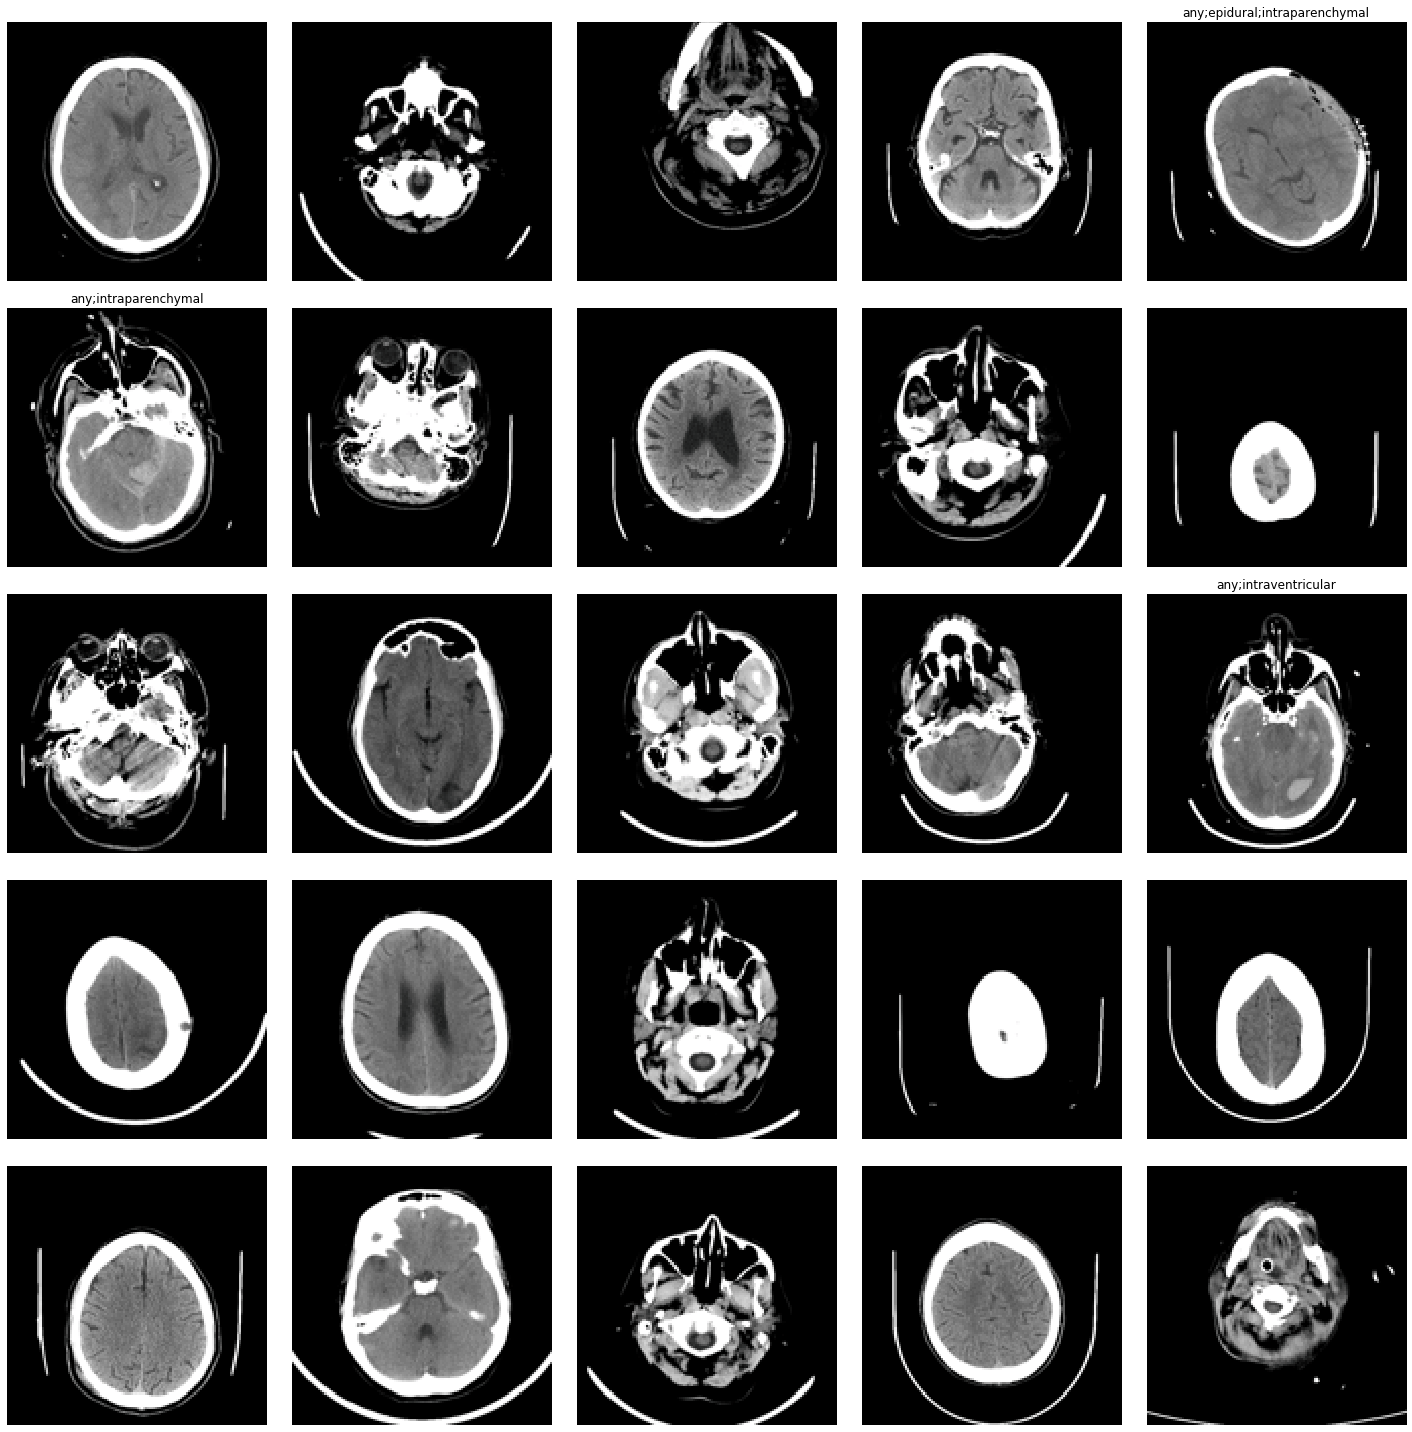

In [9]:
data.show_batch()

# About normalize

It's HC img, at first thought, we shouldn't normalize the imagenet base on imagenet stats, however, previous APOTS showed that different normalization will only affect the beginning of couple layers, and BN will take it back... For simplicity, I will just use imagenet stats in the beginning... 

In [10]:
learn = cnn_learner(data,models.resnet18,metrics=[accuracy_thresh]).to_fp16()

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.02E-02


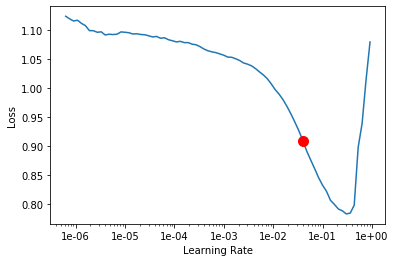

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
lr = 2e-2
learn.fit_one_cycle(2,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.122635,0.131139,0.952783,15:05
1,0.109095,0.103057,0.962441,09:03


In [14]:
learn.save('res18-1a-128')

In [11]:
learn.load('res18-1a-128');

In [12]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.25E-06


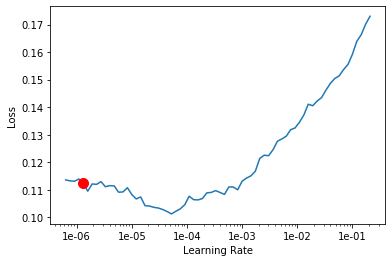

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
learn.fit_one_cycle(2,slice(5e-6/2,2e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.099465,0.095283,0.965539,15:06
1,0.084328,0.085649,0.969005,11:21


In [15]:
learn.save('res18-1a-128')

# Test Prediction

In [16]:
preds, targs = learn.get_preds(DatasetType.Test)

In [19]:
ids, labels = [], []

for fn, pred in zip(test_fns, preds):
    for i, label in enumerate(data.train_ds.classes):
        ids.append(f"{fn.split('.')[0]}_{label}")
        pred_prob = '{0:1.10f}'.format(pred[i].item())
        labels.append(pred_prob)

In [20]:
!mkdir -p {path}/submissions

In [21]:
sub_name = 'res18_baseline'
df_test = pd.DataFrame({'ID': ids, 'Label': labels})
df_test.to_csv(f'{path}/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [24]:
df_test.head()

,ID,Label
0,ID_28fbab7eb_any,0.0041019293
1,ID_28fbab7eb_epidural,0.0000802978
2,ID_28fbab7eb_intraparenchymal,0.0003625900
3,ID_28fbab7eb_intraventricular,0.0000134200
4,ID_28fbab7eb_subarachnoid,0.0015669889


In [29]:
!~/.local/bin/kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f {path}/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████| 3.90M/3.90M [00:01<00:00, 2.53MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection

# Test argumentation

In [36]:
tfms = get_transforms(flip_vert=False,  max_warp=0., max_rotate=60., max_zoom=1.1)

In [37]:
data = (ImageList
        .from_csv(path,'train_fastai_format.csv',folder='preprocessed/128/train')
        .split_by_rand_pct(seed=42)
        .label_from_df(label_delim=' ')
        .transform(tfms,size=(128,128))
        .add_test(str(path) + '/preprocessed/128/test/' + test_fns)
        .databunch(bs=64,num_workers=16)
        .normalize(imagenet_stats)
       )

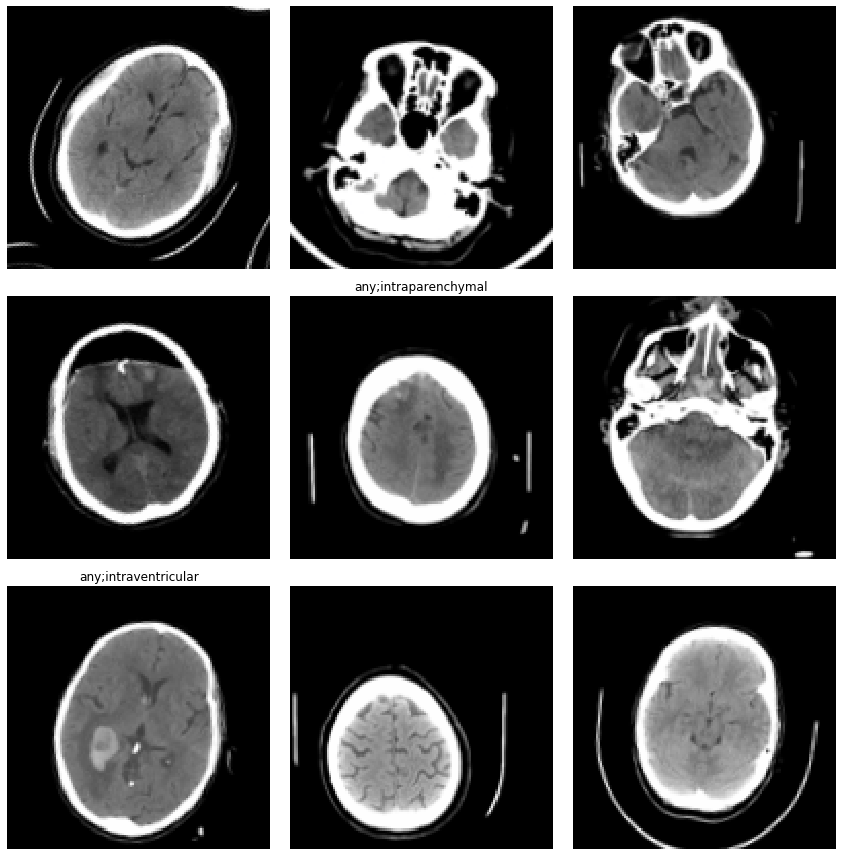

In [64]:
data.show_batch(3)

In [65]:
learn = cnn_learner(data,models.resnet18,metrics=[accuracy_thresh]).to_fp16()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 3.63E-02


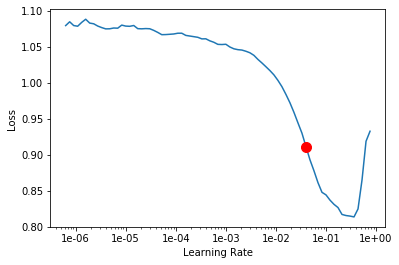

In [67]:
learn.recorder.plot(suggestion=True)

In [68]:
lr = 2e-2
learn.fit_one_cycle(2,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.127112,0.129047,0.956260,14:41
1,0.113828,0.112599,0.959638,15:09


In [69]:
learn.save('res18-arg-1a-128')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.92E-07


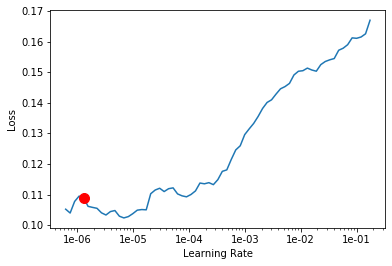

In [70]:
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(2,slice(1e-6/2,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.111413,0.105499,0.961503,16:28
